## Basic Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
import random
import numpy as np

## SEED setup for Reproducibility and deciding device

In [2]:
SEED = 1

# Apple metal or Nvidia CUDA
use_cuda = torch.cuda.is_available()
use_mps = torch.mps.is_available()

# seed for repeatablility:

# for all devices
torch.manual_seed(SEED)

# for specific acc
if use_cuda:
    print(f"Use CUDA?:{use_cuda}")
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif use_mps:
    print(f"Use MPS?: {use_mps}")
    torch.mps.manual_seed(SEED)
else:
    print("Using CPU")

random.seed(SEED)
np.random.seed(SEED)


if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

Use MPS?: True


## Transforms, datasets and dataloaders

In [3]:
# has given the best so far

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       transforms.RandomErasing(p=0.2, scale=(0.1, 0.25), ratio=(0.3, 3.3), value=0, inplace=False),# Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


# # Define a worker_init_fn for the DataLoader
# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)

# DataLoader arguments
# dataloader_args = dict(
#     shuffle=True,
#     batch_size=128,
#     num_workers=4,
#     pin_memory=True,
#     worker_init_fn=seed_worker
# ) if torch.cuda.is_available() else dict(
#     shuffle=True,
#     batch_size=64,
#     worker_init_fn=seed_worker
# )


dataloader_args = dict(shuffle=True,
                       batch_size=128,
                       num_workers=0,
                       pin_memory=True) \
                                        if use_cuda or use_mps else \
                    dict(shuffle=True,
                         batch_size=128)


train_loader = torch.utils.data.DataLoader(train,
                                           **dataloader_args)
test_loader = torch.utils.data.DataLoader(test,
                                          **dataloader_args)




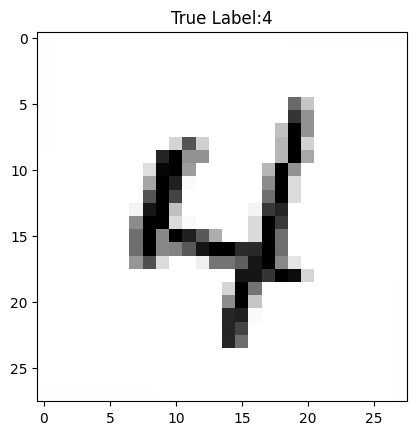

In [4]:
# tranform expects numpy data fro ToTensor
# torch.max(train_data), torch.max(train.transform(train_data.numpy()))

import matplotlib.pyplot as plt
# plt.imshow(train_data[0], cmap="gray")
# plt.show()

train_iter = iter(train_loader)
one_batch_images, one_batch_labels = next(train_iter)
sample_image, sample_label = one_batch_images[0], one_batch_labels[0]
plt.imshow(sample_image.numpy().squeeze(), cmap = "gray_r")
plt.title(f"True Label:{sample_label}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


<function matplotlib.pyplot.show(close=None, block=None)>

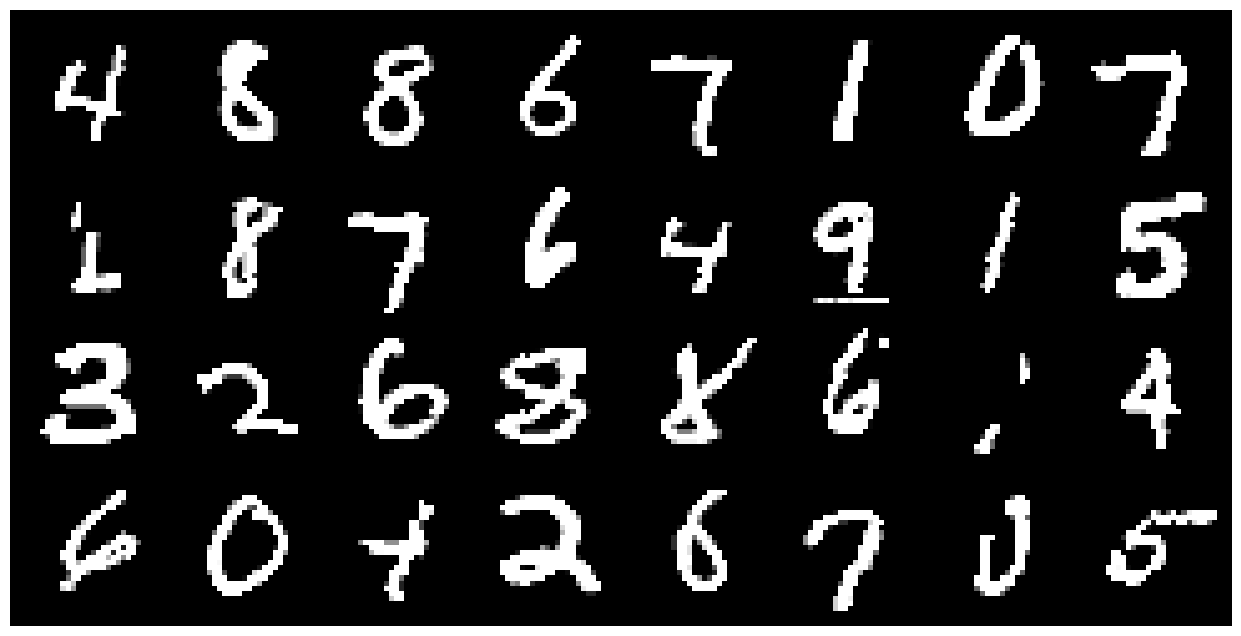

In [5]:
num_of_images = 32
nrow=8

# create a torch grid of images
grid = torchvision.utils.make_grid(one_batch_images[:num_of_images], nrow=nrow)#, normalize=True)

# permute CHW to HWC and tensor grid to numpy as expected for matplotlib imshow
grid_np = grid.permute(1,2,0).cpu().numpy()

plt.figure(figsize=(16,8))
plt.imshow(grid_np,  cmap = "gray_r")
plt.axis('off')
plt.show

## Network

### Network 3

```Target```: Improve model capacity and efficiency
- Add more params, add pool layer
- Add Image augmentation (Rotation and RandomErasing)
- Try LR scheduler experiments

 
```Results```:
- Parameters: 7,394
- Best Training Accuracy: 97.48
- Best Test Accuracy: 99.45

```Analysis```: Model is able to achieve accuracy of >99.4 consistently over last few epochs, LR scheduler parameters helped in consitency of results

```11th Epoch- 99.44, 12th Epoch-99.40, 13th Epoch-99.43, 14th Epoch-99.45```


In [6]:
dropout_p = 0.1

class MyNetwork3(nn.Module):
    def __init__(self):
        super().__init__()

        #INPUT BLOCK
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 8, 3), #inch=1, outch=8, size=26, rf=3, j=1
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
    
        #CONV BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(8,8, 3), #inch=8, outch=16, size=24, rf=5, j=1
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(8,16, 3), #inch=16, inout=32, size=22, rf=7, j=1
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(16,16, 3), #inch=16, inout=32, size=22, rf=7, j=1
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        # TRANSITION BLOCK
        #POOL LAYER
        self.convblock5 = nn.Sequential(
            nn.Conv2d(16,8,3), #inch32, outch=8, size=20, rf=9, j=1
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
    
        #CONV BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(8,8,3), #inch=8, outch=16, size=18, rf=11, j=1
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(8,16,3), #inch=8, outch=16, size=18, rf=11, j=1
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(16,16,3), #inch=16, outch=32, size=16, rf=13, j=1
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        # OUTPUT BLOCK
        self.convblock9 = nn.Sequential(
            nn.Conv2d(16,10,1), #inch=32, outch=10, size=14, rf=15, j=1
            # nn.ReLU()
        )
        #LINEAR LAYER
        # self.fc_layer = nn.Linear(10*14*14, 10)
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.dropout = nn.Dropout(dropout_p)
        self.pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        # BLOCK 1
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        # x = self.convblock4(x)
        # x = self.dropout(x)
        # TRANSITION
        x = self.pool(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        # BLOCK 2
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.dropout(x)
        x = self.convblock8(x)
        # x = self.dropout(x)
        # OUTPUT
        # x = self.convblock9(x)
        # GAP
        x = self.convblock9(x)
        x = self.gap(x)
        # x = self.convblock9(x)
        # here the shape of x will be (batch_size,10,14,14), before passing let's reshape it to (batch_size, 10*14*14)
        x = x.view(x.size(0),-1)
        
        return F.log_softmax(x, dim=1)

### Model summary

In [7]:
# !pip install torchsummary
model_3 = MyNetwork3()

In [8]:
from torchsummary import summary

summary(model_3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14              [-1, 

## Train and Test loops

In [9]:
from tqdm import tqdm

# define metrics to calc

train_losses = []
train_acc = []

test_losses = []
test_acc = []


def train(model, device, train_loader, optimizer):
    # set model to train mode
    model.train()

    # tqdm iterator
    pbar = tqdm(train_loader)

    # correct and processed vars
    correct = 0
    processed = 0

    # loop on batches of data
    for batch_idx, (data,target) in enumerate(pbar):
        #send data, targte to training device
        data, target = data.to(device), target.to(device)

        # Initialize grad to zero for the fresh batch grad accumuation
        optimizer.zero_grad()

        # pred with model
        y_pred = model(data)

        # calc loss
        batch_loss = F.nll_loss(y_pred, target)
        train_losses.append(batch_loss)

        # backprop loss to calc and acc grad w.r.t loss of batch
        batch_loss.backward()
        
        # update weights as per losses seen in this batch
        optimizer.step()

        # calculate correct pred count and acc for batch
        pred_labels = y_pred.argmax(dim=1, keepdim=True)
        correct_count_batch = pred_labels.eq(target.view_as(pred_labels)).sum().item()

        # update total correct and total processed so far
        correct+= correct_count_batch
        processed+= len(data)

        # set pbar desc
        pbar.set_description(desc=f'batch Loss = {batch_loss.item()} batch_id = {batch_idx} accuracy = {100*correct/processed:.02f}'
                            )
        #append train acc
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    # set model to eval mode
    model.eval()

    # define var to calc correct and processed
    correct = 0
    processed = 0
    test_loss = 0 # seeing loss as the code runs has no value for test

    # set a no grad context
    with torch.no_grad():
        for data,target in test_loader:
            #send data, target to device
            data, target = data.to(device), target.to(device)
    
            # do pred
            y_pred = model(data)
    
            #calc loss for batch as summed and update total test loss
            batch_loss = F.nll_loss(y_pred, target, reduction='sum').item()
            test_loss+= batch_loss
            # collect loss
            test_losses.append(batch_loss)
    
            # count correct
            pred_labels = y_pred.argmax(dim=1, keepdim=True)
            correct_batch = pred_labels.eq(target.view_as(pred_labels)).sum().item()
    
            #update correct
            correct+= correct_batch
            processed+= len(data)

    # avg loss on test makes more sense to avg it
    test_loss/= processed
    # collect avg losses
    test_losses.append(test_loss)

    print(f'\n Test set avg loss: {test_loss:.4f} \
                Accuracy: {correct}/{processed}, {100*correct/processed:.2f}'
         )

    test_acc.append(100*correct/processed)

    return test_loss, round(100*correct/processed, 1)
        
    

## Train for n Epochs

In [10]:
# train with scheduler

# initialize model on device
model = model_3.to(device)

# initialize optimizer with model params and lr
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-7)

# let's try a lr scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=0)#, min_lr=0.000640)

# Set total epochs
EPOCHS = 14

for epoch in range(EPOCHS):
    print(f'EPOCH: {epoch}')
    train(model, device, train_loader, optimizer)
    last_test_loss, last_test_acc = test(model, device, test_loader)
    scheduler.step(last_test_acc)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1}, test_acc: {last_test_acc} Learning Rate: {current_lr:.6f}")

    

EPOCH: 0



atch Loss = 0.10049688816070557 batch_id = 468 accuracy = 90.03: 100%|█| 469/469 [00:11<00:00, 40.63it/s]


 Test set avg loss: 0.0582                 Accuracy: 9818/10000, 98.18
Epoch 1, test_acc: 98.2 Learning Rate: 0.010000
EPOCH: 1



atch Loss = 0.11990588903427124 batch_id = 468 accuracy = 95.03: 100%|█| 469/469 [00:11<00:00, 40.72it/s]


 Test set avg loss: 0.0400                 Accuracy: 9885/10000, 98.85
Epoch 2, test_acc: 98.8 Learning Rate: 0.010000
EPOCH: 2



atch Loss = 0.10071399807929993 batch_id = 468 accuracy = 95.79: 100%|█| 469/469 [00:12<00:00, 37.97it/s]


 Test set avg loss: 0.0376                 Accuracy: 9882/10000, 98.82
Epoch 3, test_acc: 98.8 Learning Rate: 0.006000
EPOCH: 3



atch Loss = 0.12180774658918381 batch_id = 468 accuracy = 96.31: 100%|█| 469/469 [00:12<00:00, 37.62it/s]


 Test set avg loss: 0.0324                 Accuracy: 9902/10000, 99.02
Epoch 4, test_acc: 99.0 Learning Rate: 0.006000
EPOCH: 4



atch Loss = 0.05476018786430359 batch_id = 468 accuracy = 96.50: 100%|█| 469/469 [00:11<00:00, 40.87it/s]


 Test set avg loss: 0.0279                 Accuracy: 9910/10000, 99.10
Epoch 5, test_acc: 99.1 Learning Rate: 0.006000
EPOCH: 5



atch Loss = 0.15376223623752594 batch_id = 468 accuracy = 96.66: 100%|█| 469/469 [00:10<00:00, 42.66it/s]


 Test set avg loss: 0.0303                 Accuracy: 9907/10000, 99.07
Epoch 6, test_acc: 99.1 Learning Rate: 0.003600
EPOCH: 6



atch Loss = 0.13556037843227386 batch_id = 468 accuracy = 97.06: 100%|█| 469/469 [00:12<00:00, 38.64it/s]


 Test set avg loss: 0.0239                 Accuracy: 9930/10000, 99.30
Epoch 7, test_acc: 99.3 Learning Rate: 0.003600
EPOCH: 7



atch Loss = 0.05357492342591286 batch_id = 468 accuracy = 96.99: 100%|█| 469/469 [00:11<00:00, 42.47it/s]


 Test set avg loss: 0.0229                 Accuracy: 9925/10000, 99.25
Epoch 8, test_acc: 99.2 Learning Rate: 0.002160
EPOCH: 8



atch Loss = 0.10341391712427139 batch_id = 468 accuracy = 97.23: 100%|█| 469/469 [00:10<00:00, 42.95it/s]


 Test set avg loss: 0.0234                 Accuracy: 9938/10000, 99.38
Epoch 9, test_acc: 99.4 Learning Rate: 0.002160
EPOCH: 9



atch Loss = 0.09649048000574112 batch_id = 468 accuracy = 97.22: 100%|█| 469/469 [00:11<00:00, 41.88it/s]


 Test set avg loss: 0.0201                 Accuracy: 9938/10000, 99.38
Epoch 10, test_acc: 99.4 Learning Rate: 0.001296
EPOCH: 10



atch Loss = 0.09794212132692337 batch_id = 468 accuracy = 97.43: 100%|█| 469/469 [00:10<00:00, 43.67it/s]


 Test set avg loss: 0.0198                 Accuracy: 9944/10000, 99.44
Epoch 11, test_acc: 99.4 Learning Rate: 0.000778
EPOCH: 11



atch Loss = 0.04615223407745361 batch_id = 468 accuracy = 97.35: 100%|█| 469/469 [00:11<00:00, 41.48it/s]


 Test set avg loss: 0.0207                 Accuracy: 9940/10000, 99.40
Epoch 12, test_acc: 99.4 Learning Rate: 0.000467
EPOCH: 12



atch Loss = 0.1392127126455307 batch_id = 468 accuracy = 97.40: 100%|██| 469/469 [00:10<00:00, 43.30it/s]


 Test set avg loss: 0.0191                 Accuracy: 9943/10000, 99.43
Epoch 13, test_acc: 99.4 Learning Rate: 0.000280
EPOCH: 13



atch Loss = 0.055487751960754395 batch_id = 468 accuracy = 97.48: 100%|█| 469/469 [00:10<00:00, 43.51it/s


 Test set avg loss: 0.0189                 Accuracy: 9945/10000, 99.45
Epoch 14, test_acc: 99.5 Learning Rate: 0.000280
